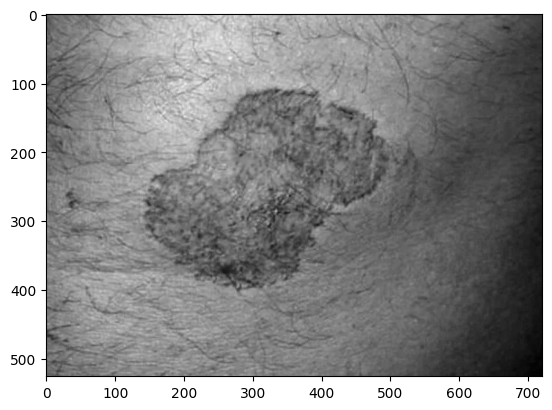

In [23]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

src = cv2.imread("C:\\Users\\Priyanka Joshi\\Downloads\\hairremove kaggle copy\\Basal-Cell-Carcinoma-1296x728-slide3-1024x575.jpg")

# Convert the original image to grayscale
grayScale = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)

plt.imshow(grayScale,cmap='gray')

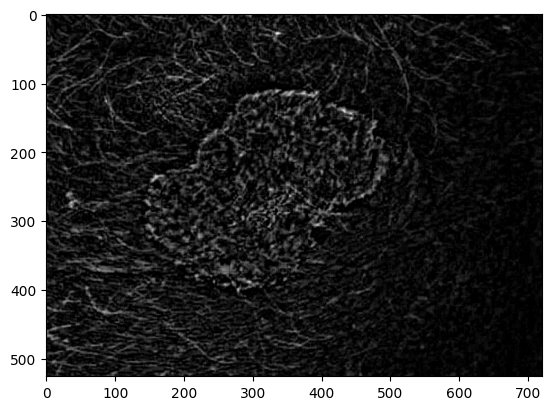

In [24]:
# kernel for morphologyEx
kernel = cv2.getStructuringElement(1,(21,21))
    
# apply MORPH_BLACKHAT to grayScale image
blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
plt.imshow(blackhat,cmap='gray')


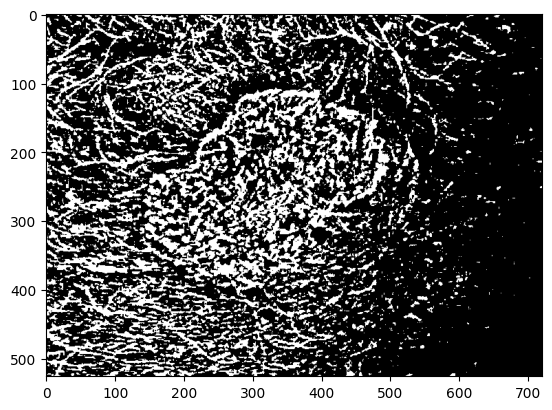

In [45]:
# apply thresholding to blackhat
_,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    
plt.imshow(threshold,cmap='gray')

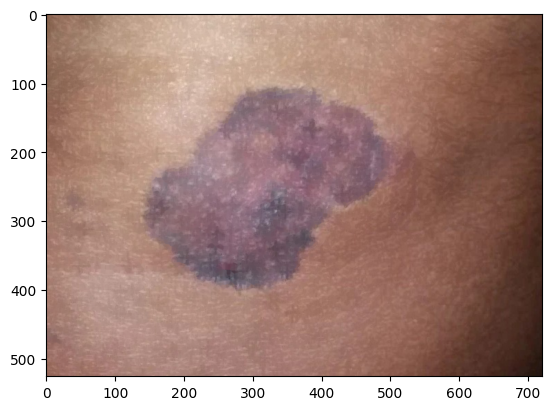

In [46]:
# inpaint with original image and threshold image
final_img = cv2.inpaint(src,threshold,1,cv2.INPAINT_TELEA)
dst_rgb = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)

plt.imshow(dst_rgb,cmap='gray')

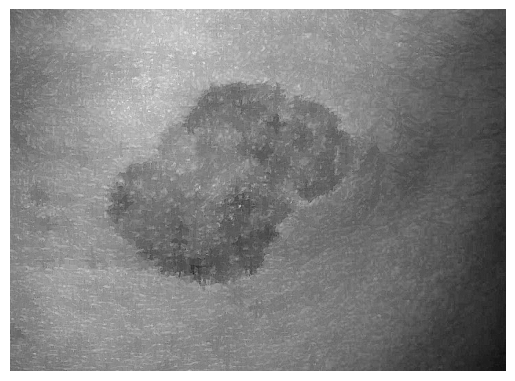

In [62]:
# Define sharpening kernel
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

# Convert the inpainted image to grayscale for sharpening
gray_sharpen = cv2.cvtColor(dst_rgb, cv2.COLOR_RGB2GRAY)

# Apply sharpening filter
sharpened = cv2.filter2D(gray_sharpen, -1, kernel)

# Display result
plt.imshow(sharpened, cmap='gray')
plt.axis("off")
plt.show()


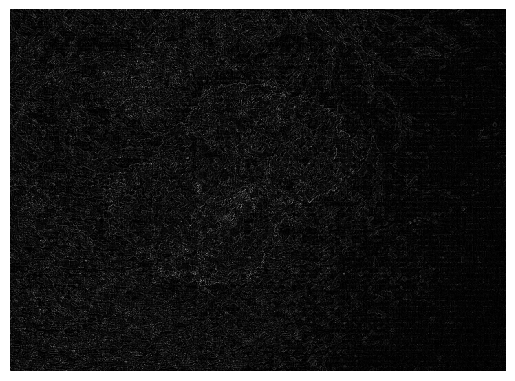

In [64]:
laplacian_kernel = np.array([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]], dtype=np.float32)

laplacian_edges = cv2.filter2D(sharpened, -1, laplacian_kernel)

# Convert to absolute scale
laplacian_edges_abs = cv2.convertScaleAbs(laplacian_edges)

plt.imshow(laplacian_edges_abs, cmap='gray')
plt.axis("off")
plt.show()

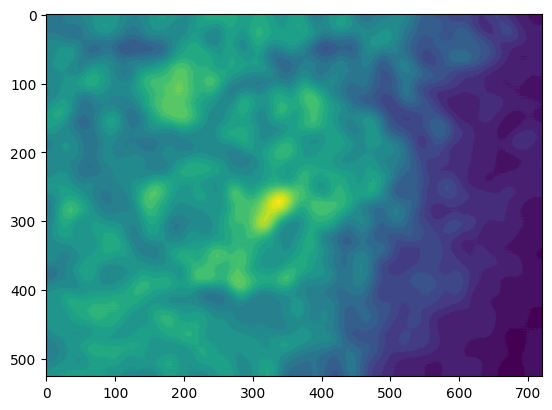

In [69]:
blurred = cv2.GaussianBlur(laplacian_edges_abs, (75, 75), 0)
plt.imshow(blurred)

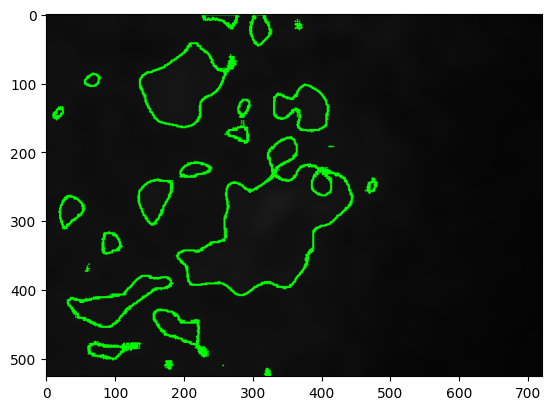

In [ ]:
# Method 1: Simple Thresholding (Fixed Threshold)
_, binary_thresh = cv2.threshold(blurred, 17, 35, cv2.THRESH_BINARY)

# Detect edges using Canny Edge Detection
edges = cv2.Canny(binary_thresh, 10, 255)

# Find contours from bright areas
contours, _ = cv2.findContours(binary_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on a copy of the original image
contour_image = cv2.cvtColor(blurred, cv2.COLOR_GRAY2BGR)  # Convert to BGR for colored contours
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)  # Green contour

plt.imshow(contour_image)






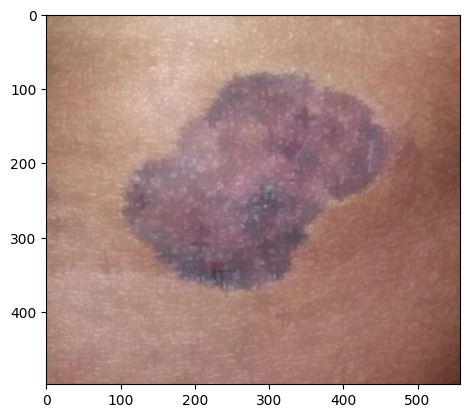

In [71]:
margin = 150

if contours:
    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Draw the contour on the image (for visualization)
    cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 2)

    # Get bounding box around the detected lesion
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Add margin and ensure boundaries don't exceed image size
    x_start = max(x - margin, 0)
    y_start = max(y - margin, 0)
    x_end = min(x + w + margin, sharpened.shape[1])
    y_end = min(y + h + margin, sharpened.shape[0])

    # Crop with margin
    lesion_crop = dst_rgb[y_start:y_end, x_start:x_end]
    #lesion_crop_rgb = cv2.cvtColor(lesion_crop, cv2.COLOR_BGR2RGB)
    
    plt.imshow(lesion_crop)